# **BirdCLEF 2025 Data Preprocessing Notebook**
This notebook demonstrates how we can transform audio data into mel-spectrogram data. This transformation is essential for training 2D Convolutional Neural Networks (CNNs) on audio data, as it converts the one-dimensional audio signals into two-dimensional image-like representations.
I run this public notebook in debug mode(only a few sample processing). You can find the fully preprocessed mel spectrogram training dataset here --> [BirdCLEF'25 | Mel Spectrograms](https://www.kaggle.com/datasets/kadircandrisolu/birdclef25-mel-spectrograms).

In [3]:
import os
import cv2
import math
import time
import librosa
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import pickle

import torch
import warnings
warnings.filterwarnings("ignore")

In [4]:
class Config:
 
    DEBUG_MODE = False
    
    OUTPUT_DIR = './working/'
    DATA_ROOT = './Data'
    FS = 32000
    
    # Mel spectrogram parameters
    N_FFT = 1024
    HOP_LENGTH = 512
    N_MELS = 128
    FMIN = 50
    FMAX = 14000

    EXCLUDE_HUMAN_VOICE = True
    NOHUMAN_DURATION = 5.0

    OVERSAMPLE_THRESHOLD = 200
    
    TARGET_DURATION = 5.0
    TARGET_SHAPE = (256, 256)  
    
    N_MAX = 50 if DEBUG_MODE else None  

config = Config()

In [5]:
print(f"Debug mode: {'ON' if config.DEBUG_MODE else 'OFF'}")
print(f"Max samples to process: {config.N_MAX if config.N_MAX is not None else 'ALL'}")

print("Loading taxonomy data...")
taxonomy_df = pd.read_csv(f'{config.DATA_ROOT}/taxonomy.csv')
species_class_map = dict(zip(taxonomy_df['primary_label'], taxonomy_df['class_name']))

print("Load vocal data...")
with open("train_voice_data.pkl", "rb") as fr :
    voice_dict = pickle.load(fr)

print("Loading training metadata...")
train_df = pd.read_csv(f'{config.DATA_ROOT}/train.csv')

Debug mode: OFF
Max samples to process: ALL
Loading taxonomy data...
Load vocal data...
Loading training metadata...


In [8]:
label_list = sorted(train_df['primary_label'].unique())
label_id_list = list(range(len(label_list)))
label2id = dict(zip(label_list, label_id_list))
id2label = dict(zip(label_id_list, label_list))

print(f'Found {len(label_list)} unique species')
working_df = train_df[['primary_label', 'rating', 'filename']].copy()
working_df['target'] = working_df.primary_label.map(label2id)
working_df['filepath'] = config.DATA_ROOT + '/train_audio/' + working_df.filename
working_df['samplename'] = working_df.filename.map(lambda x: x.split('/')[0] + '-' + x.split('/')[-1].split('.')[0])
working_df['class'] = working_df.primary_label.map(lambda x: species_class_map.get(x, 'Unknown'))
total_samples = min(len(working_df), config.N_MAX or len(working_df))
print(f'Total samples to process: {total_samples} out of {len(working_df)} available')
print(f'Samples by class:')
print(working_df['class'].value_counts())
voice_file_dict = {key[40:]: value for key, value in voice_dict.items()} # remove /kaggle/input/birdclef-2025/train_audio/


Found 206 unique species
Total samples to process: 28564 out of 28564 available
Samples by class:
class
Aves        27648
Amphibia      583
Mammalia      178
Insecta       155
Name: count, dtype: int64


In [11]:
def audio2melspec(audio_data):
    if np.isnan(audio_data).any():
        mean_signal = np.nanmean(audio_data)
        audio_data = np.nan_to_num(audio_data, nan=mean_signal)

    mel_spec = librosa.feature.melspectrogram(
        y=audio_data,
        sr=config.FS,
        n_fft=config.N_FFT,
        hop_length=config.HOP_LENGTH,
        n_mels=config.N_MELS,
        fmin=config.FMIN,
        fmax=config.FMAX,
        power=2.0
    )

    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    mel_spec_norm = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min() + 1e-8)
    mel_spec_power_norm = (mel_spec - mel_spec.min()) / (mel_spec.max() - mel_spec.min() + 1e-8)

    
    return (mel_spec_norm, mel_spec_db, mel_spec_norm, mel_spec_power_norm)

In [ ]:
## Changelog : Remove cyclic padding, only add zero padding (equally on both sides)

print("Starting audio processing...")
print(f"{'DEBUG MODE - Processing only 50 samples' if config.DEBUG_MODE else 'FULL MODE - Processing all samples'}")
start_time = time.time()

all_bird_data = {}
errors = []

for i, row in working_df.iterrows(): #tqdm(working_df.iterrows(), total=total_samples):
    if config.N_MAX is not None and i >= config.N_MAX:
        break
    
    try:
        audio_data, _ = librosa.load(row.filepath, sr=config.FS)

        target_samples = int(config.TARGET_DURATION * config.FS)

        if row.filename in voice_file_dict :
            voicearray = voice_file_dict[row.filename]
            novdurations = []
            # Start counting until it hits first 'start'
            novdurations.append(voicearray[0]['start']) # first novoice
            for i in range(len(voicearray)-1) :
                novdurations.append(voicearray[i+1]['start']-voicearray[i]['end'])
            novdurations.append(len(audio_data)-voicearray[len(voicearray)-1]['end'])
            # added all blank lengths in novdurations
            





        if len(audio_data) < target_samples:
            left_pad = int((target_samples - len(audio_data))/2)
            right_pad = int(target_samples-len(audio_data)-left_pad)
            audio_data = np.pad(audio_data, (left_pad, right_pad), mode='constant')
        start_idx = int(len(audio_data) / 2 - target_samples / 2)
        center_audio = audio_data[start_idx:start_idx+target_samples]

        if len(center_audio) < target_samples:
            center_audio = np.pad(center_audio, 
                                 (0, target_samples - len(center_audio)), 
                                 mode='constant')

        mel_spec = audio2melspec(center_audio)[0]

        if mel_spec.shape != config.TARGET_SHAPE:
            mel_spec = cv2.resize(mel_spec, config.TARGET_SHAPE, interpolation=cv2.INTER_LINEAR)

        all_bird_data[row.samplename] = mel_spec.astype(np.float32)
        
    except Exception as e:
        print(f"Error processing {row.filepath}: {e}")
        errors.append((row.filepath, str(e)))

end_time = time.time()
print(f"Processing completed in {end_time - start_time:.2f} seconds")
print(f"Successfully processed {len(all_bird_data)} files out of {total_samples} total")
print(f"Failed to process {len(errors)} files")

Starting audio processing...
FULL MODE - Processing all samples
Processing completed in 1436.45 seconds
Successfully processed 28564 files out of 28564 total
Failed to process 0 files


In [7]:
np.save('0405initial.npy', all_bird_data)

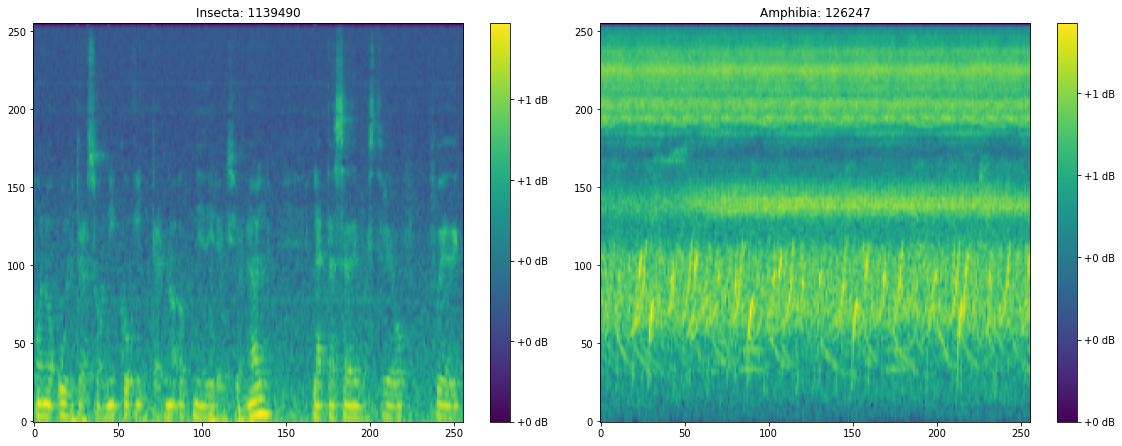

In [19]:
import matplotlib.pyplot as plt

samples = []
displayed_classes = set()

max_samples = min(4, len(all_bird_data))

for i, row in working_df.iterrows():
    if i >= (config.N_MAX or len(working_df)):
        break
        
    if row['samplename'] in all_bird_data:
        if config.DEBUG_MODE:
            if row['class'] not in displayed_classes:
                samples.append((row['samplename'], row['class'], row['primary_label']))
                displayed_classes.add(row['class'])
        else:
            if row['class'] not in displayed_classes:
                samples.append((row['samplename'], row['class'], row['primary_label']))
                displayed_classes.add(row['class'])
        
        if len(samples) >= max_samples:  
            break

if samples:
    plt.figure(figsize=(16, 12))
    
    for i, (samplename, class_name, species) in enumerate(samples):
        plt.subplot(2, 2, i+1)
        plt.imshow(all_bird_data[samplename], aspect='auto', origin='lower', cmap='viridis')
        plt.title(f"{class_name}: {species}")
        plt.colorbar(format='%+2.0f dB')
    
    plt.tight_layout()
    debug_note = "debug_" if config.DEBUG_MODE else ""
    plt.savefig(f'{debug_note}melspec_examples.png')
    plt.show()